In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, warnings, time, datetime, random, pickle

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, TimeSeriesSplit, GroupKFold

from sklearn.linear_model import LogisticRegression

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [3]:
TARGET = "k_class"
SEED = 42
seed_everything(SEED)

In [4]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [5]:
def kfold_logistic_regression(train_file_path, test_file_path, num_folds, stratified=False):
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)
    
    train_df = pd.read_pickle(train_file_path)
    test_df  = pd.read_pickle(test_file_path)
    
    train_df.columns = range(0, 38)
    test_df.columns = range(0, 38)
    df = pd.read_pickle("./structure_df_01.pkl")
    train_df["k_class"] = df["k_class"]

    feats = list(range(0, 38))
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
            
    scores = []
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df[TARGET])):
        print(f"Fold: {n_fold}")
        train_x, train_y = train_df[feats].iloc[train_idx], train_df[TARGET].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df[TARGET].iloc[valid_idx]
        
        train_x = train_x.to_numpy()
        train_y = train_y.to_numpy()
        valid_x = valid_x.to_numpy()
        valid_y = valid_y.to_numpy()
        
        model = LogisticRegression(solver='liblinear', multi_class='ovr', n_jobs=-1)
                
        model.fit(train_x, train_y)
        scores.append(model.score(valid_x, valid_y))
        
        del train_x, train_y
        gc.collect()
                
        oof_preds[valid_idx] = model.predict_proba(valid_x)[:,1]
            
    train_df.loc[:, "pred"] = model.predict(test_df[feats])
    
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure()
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(np.array(feats)[sorted_idx], fontsize=8)
    featax.set_xlabel('Relative Feature Importance')
    
    feature_importance_df = pd.DataFrame()
    feature_importance_df["feature"] = np.array(feats)[sorted_idx]
    feature_importance_df["importance"] = feature_importance[sorted_idx]
    feature_importance_df.to_csv("feature_importance_lr.csv", index=False)
    
    plt.tight_layout()   
    plt.show()
    
    return train_df

Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4


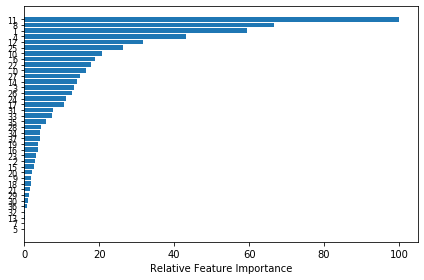

Run Logistic Regression with kfold - done in 2s


In [6]:
submission = None
with timer("Run Logistic Regression with kfold"):
    submission = kfold_logistic_regression(
        train_file_path="./structure_train_01.pkl", 
        test_file_path="./structure_train_01.pkl", 
        num_folds=5, stratified=False)

df = pd.read_pickle("./structure_df_01.pkl")
df["pred"] = submission["pred"]
df.to_csv("./logistic-regression.csv", index=False)